In [1]:
#Libraries
import numpy as np
import os
import pandas as pd
import pickle
from google.colab import drive
import codecs
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stemmer = PorterStemmer() 
from google.colab import files
from tensorflow.keras import datasets, layers, models, optimizers, metrics, Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import keras
import  xgboost, textblob, string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


In [227]:
keras.__version__

'2.3.1'

In [2]:
# mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Here make sure you upload the *Gutenberg_English_Fiction_1k* folder to your google drive.

In [3]:
#reading the data
data_pd = pd.read_csv('drive/My Drive/Gutenberg_English_Fiction_1k/master996.csv', sep=';', encoding='ISO-8859-1')
#displaying data
data_pd

,Book_Name,book_id,guten_genre,Author_Name
0,The Mystery of the Boule Cabinet: A Detective ...,pg10067.epub,Detective and Mystery,Stevenson| Burton Egbert
1,The Pupil,pg1032.epub,Literary,James| Henry
2,At Love's Cost,pg10379.epub,Literary,Garvice| Charles
3,The Heart of the Range,pg10473.epub,Western Stories,White| William Patterson
4,The Worshipper of the Image,pg10812.epub,Literary,Gallienne| Richard Le
...,...,...,...,...
991,David Copperfield,pg766DickensDavidCopfld.epub,Literary,Dickens| Charles
992,Hard Times,pg786DickensHardTimes.epub,Literary,Dickens| Charles
993,Memoirs of Shelock Holmes,pg834DoyleMemoirsSherlk.epub,Detective and Mystery,Connan| Doyle
994,The Mysterious Affair at Styles,pg863Agatha1.epub,Detective and Mystery,Christie| Agatha


In [4]:
# reading the file objects and storing in an array
object_list = []
for i in range(data_pd.shape[0]):
  file_epub = data_pd['book_id'][i]
  # the file name in csv and actual conten-file name is different.
  # Hence renaming it to read the data.
  content_file_name = file_epub.replace(".epub", "-content.html")
  f = codecs.open('drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/' + content_file_name, 'r')
  # here 'f' is just an object. To read actual data in object use 'f.read()'.
  object_list.append(f)
object_array = np.array(object_list)

In [5]:
# displaying content_file objects
print("Example 5 object representation")
print(object_array[0:5])

Example 5 object representation
[<_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10067-content.html' mode='r' encoding='UTF-8'>
 <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg1032-content.html' mode='r' encoding='UTF-8'>
 <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10379-content.html' mode='r' encoding='UTF-8'>
 <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10473-content.html' mode='r' encoding='UTF-8'>
 <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10812-content.html' mode='r' encoding='UTF-8'>]


In [6]:
#labels
labels = data_pd['guten_genre']
labels

0      Detective and Mystery
1                   Literary
2                   Literary
3            Western Stories
4                   Literary
               ...          
991                 Literary
992                 Literary
993    Detective and Mystery
994    Detective and Mystery
995                 Literary
Name: guten_genre, Length: 996, dtype: object

In [7]:
labels.value_counts()

Literary                       794
Detective and Mystery          111
Sea and Adventure               36
Western Stories                 18
Love and Romance                18
Humorous and Wit and Satire      6
Ghost and Horror                 6
Christmas Stories                5
Allegories                       2
Name: guten_genre, dtype: int64

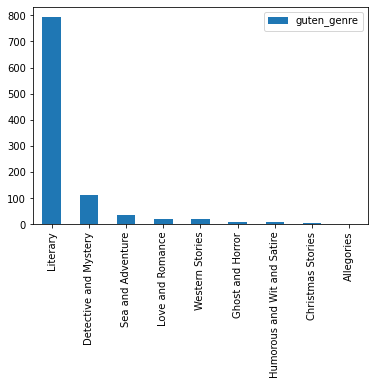

In [8]:
temp = data_pd['guten_genre'].value_counts().sort_values(ascending=False)
temp = pd.DataFrame(temp)
ax = temp.plot.bar()

In [9]:
if(os.path.exists("drive/My Drive/Gutenberg_English_Fiction_1k/data_pickle")):
  infile = open("drive/My Drive/Gutenberg_English_Fiction_1k/data_pickle", "rb")
  file_contents = pickle.load(infile)
  infile.close()
else:
  file_contents = []
  for i in range(object_array.shape[0]):
    print('reading file', data_pd['book_id'][i], 'file no', i)
    f = object_array[i].read()
    #f = f.replace('<p>', '')
    #f = f.replace('\n', ' ')
    #f = f.replace('\'', '')
    for r in (('<p>', ''), ('\n', ' '), ('\'', '')):
      f = f.replace(*r)
    file_contents.append(f)
  outfile = open("data_pickle", "wb")
  pickle.dump(file_contents, outfile)
  files.download("data_pickle")
#converting data to numpy array
file_contents_array = np.array(file_contents)

In [10]:
#delete file_contents, so we can save space.
del(file_contents)

Section 1: **Deep learning oriented.**

In [11]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
count_vect = CountVectorizer(analyzer='word', max_features = 40000, token_pattern=r'\w{1,}')
count_vect.fit(file_contents_array)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=40000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [123]:
len(count_vect.get_feature_names())

40000

In [12]:
object_pd = pd.Series(object_array)
labels_pd = labels

In [125]:
print(type(object_pd))
print(type(labels_pd))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [126]:
labels_pd.values

array(['Detective and Mystery', 'Literary', 'Literary', 'Western Stories',
       'Literary', 'Literary', 'Detective and Mystery', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Ghost and Horror', 'Literary', 'Literary',
       'Literary', 'Literary', 'Detective and Mystery', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Christmas Stories',
       'Love and Romance', 'Literary', 'Love and Romance',
       'Sea and Adventure', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Li

In [127]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(object_pd, labels_pd)

In [128]:
train_y

323    Detective and Mystery
149                 Literary
221                 Literary
344                 Literary
314                 Literary
               ...          
89                  Literary
141    Detective and Mystery
931                 Literary
47                  Literary
540    Detective and Mystery
Name: guten_genre, Length: 747, dtype: object

In [129]:
object_pd.values

array([<_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10067-content.html' mode='r' encoding='UTF-8'>,
       <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg1032-content.html' mode='r' encoding='UTF-8'>,
       <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10379-content.html' mode='r' encoding='UTF-8'>,
       <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10473-content.html' mode='r' encoding='UTF-8'>,
       <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10812-content.html' mode='r' encoding='UTF-8'>,
       <_io.TextIOWrapper name='drive/My Drive/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/pg10826-content.html' mode='r' encoding='UTF-8'>,
       <_io

In [130]:
train_x.index[0]

323

In [131]:
num_genres = len(pd.unique(labels_pd))
num_genres

9

In [132]:
train_y = np.array(train_y[:])
valid_y = np.array(valid_y[:])

In [133]:
train_y

array(['Detective and Mystery', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Detective and Mystery', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Detective and Mystery', 'Literary', 'Literary', 'Literary',
       'Detective and Mystery', 'Literary', 'Literary',
       'Detective and Mystery', 'Literary', 'Detective and Mystery',
       'Literary', 'Literary', 'Literary', 'Literary',
       'Detective and Mystery', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Western Stories', 'Detective and Mystery',
       'Sea and Adventure', 'Literary', 'Literary', 'Literary',
       'Love and Romance', 'Literary', 'Literary', 'Literary', 'Literary',
       'Literary', 'Literary', 'Detective and Mystery', 'Literary',
       'Detective and Mystery', 'Sea and Adventure', 'Literary',
       'Literary', 'Literary', 'Literary', 'Literary', 'Literary',


In [134]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(labels)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)

- One-hot Encoding

In [136]:
#skipping for now
train_y = keras.utils.to_categorical(train_y, num_genres) 
valid_y = keras.utils.to_categorical(valid_y, num_genres)
train_y[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [137]:
tx = []
for i in train_x.index:
  print('file', i, 'is  processing in train set')  
  tx.append(count_vect.transform([file_contents_array[i]]))
train_data = np.array(tx)

vx = []
for j in valid_x.index:
  print('file', j, 'is  processing in test set') 
  vx.append(count_vect.transform([file_contents_array[j]]))
test_data = np.array(vx)

file 323 is  processing in train set
file 149 is  processing in train set
file 221 is  processing in train set
file 344 is  processing in train set
file 314 is  processing in train set
file 466 is  processing in train set
file 795 is  processing in train set
file 725 is  processing in train set
file 131 is  processing in train set
file 446 is  processing in train set
file 231 is  processing in train set
file 407 is  processing in train set
file 956 is  processing in train set
file 777 is  processing in train set
file 709 is  processing in train set
file 78 is  processing in train set
file 730 is  processing in train set
file 960 is  processing in train set
file 792 is  processing in train set
file 745 is  processing in train set
file 184 is  processing in train set
file 13 is  processing in train set
file 495 is  processing in train set
file 2 is  processing in train set
file 5 is  processing in train set
file 412 is  processing in train set
file 483 is  processing in train set
file 80

In [138]:
deSparseList = []
for i in range(train_data.shape[0]):
  deSparseList.append(train_data[i].toarray().reshape(-1))
train_x = np.array(deSparseList)

In [139]:
deSparseList = []
for i in range(test_data.shape[0]):
  deSparseList.append(test_data[i].toarray().reshape(-1))
test_x = np.array(deSparseList)

In [140]:
train_x = tf.convert_to_tensor(train_x)
test_x = tf.convert_to_tensor(test_x)

In [141]:
train_x

<tf.Tensor: shape=(747, 40000), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [142]:
tf.keras.backend.clear_session()

- **Multi Layer Perceptron** with Count Vectors
  - This model considered as base model to compare the results.

In [143]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(2048, activation=tf.nn.relu, input_shape=(train_x.shape[1],)),
                                    tf.keras.layers.Dropout(0.2), 
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(9, activation=tf.nn.softmax)])

In [144]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              81922048  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 2

In [146]:
model.fit(train_x, train_y, epochs=20)

Epoch 1/20
24/24 [==============================] - 1s 40ms/step - loss: 59.8801 - accuracy: 0.6265
Epoch 2/20
24/24 [==============================] - 1s 36ms/step - loss: 11.9598 - accuracy: 0.6814
Epoch 3/20
24/24 [==============================] - 1s 36ms/step - loss: 3.7744 - accuracy: 0.6680
Epoch 4/20
24/24 [==============================] - 1s 36ms/step - loss: 2.0898 - accuracy: 0.7764
Epoch 5/20
24/24 [==============================] - 1s 36ms/step - loss: 0.9635 - accuracy: 0.8367
Epoch 6/20
24/24 [==============================] - 1s 36ms/step - loss: 0.8598 - accuracy: 0.8568
Epoch 7/20
24/24 [==============================] - 1s 37ms/step - loss: 0.5656 - accuracy: 0.8929
Epoch 8/20
24/24 [==============================] - 1s 36ms/step - loss: 0.4987 - accuracy: 0.8902
Epoch 9/20
24/24 [==============================] - 1s 36ms/step - loss: 0.5700 - accuracy: 0.8929
Epoch 10/20
24/24 [==============================] - 1s 36ms/step - loss: 0.4401 - accuracy: 0.9090
Epoch 1

In [147]:
model.evaluate(test_x, valid_y)

8/8 [==============================] - 0s 10ms/step - loss: 1.6578 - accuracy: 0.8795


[1.6578487157821655, 0.8795180916786194]

- With 

In [148]:
tf.keras.backend.clear_session()

In [164]:
train_x = np.array(train_x)
train_x = train_x.reshape(-1,200,200)
train_x.shape
test_x = np.array(test_x)
test_x = test_x.reshape(-1,200,200)
test_x.shape

(249, 200, 200)

In [166]:
train_x = tf.convert_to_tensor(train_x)
test_x = tf.convert_to_tensor(test_x)

TensorShape([747, 200, 200])

- Let's try **Convolutional neural** networks

In [175]:
model = Sequential([tf.keras.layers.Conv1D(1000, 3, padding='valid', activation='relu', strides=1, input_shape = (200, 200)),
                    tf.keras.layers.GlobalMaxPooling1D(),
                    tf.keras.layers.Dense(256),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Activation('relu'),
                    tf.keras.layers.Dense(9, activation=tf.nn.softmax)])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [176]:
model.fit(train_x, train_y, epochs=20)
model.summary()

Epoch 1/20
24/24 [==============================] - 1s 26ms/step - loss: 145.9727 - accuracy: 0.6452
Epoch 2/20
24/24 [==============================] - 0s 21ms/step - loss: 82.4070 - accuracy: 0.6934
Epoch 3/20
24/24 [==============================] - 0s 20ms/step - loss: 29.6946 - accuracy: 0.6934
Epoch 4/20
24/24 [==============================] - 1s 21ms/step - loss: 8.1214 - accuracy: 0.6667
Epoch 5/20
24/24 [==============================] - 1s 21ms/step - loss: 1.3450 - accuracy: 0.7456
Epoch 6/20
24/24 [==============================] - 1s 21ms/step - loss: 1.1626 - accuracy: 0.7657
Epoch 7/20
24/24 [==============================] - 1s 21ms/step - loss: 1.3653 - accuracy: 0.7523
Epoch 8/20
24/24 [==============================] - 1s 21ms/step - loss: 1.1567 - accuracy: 0.7858
Epoch 9/20
24/24 [==============================] - 0s 21ms/step - loss: 1.8015 - accuracy: 0.7617
Epoch 10/20
24/24 [==============================] - 1s 21ms/step - loss: 1.9981 - accuracy: 0.7282
Epoch

In [179]:
model.evaluate(test_x, valid_y)

8/8 [==============================] - 0s 17ms/step - loss: 1.0341 - accuracy: 0.7871


[1.034065842628479, 0.7871485948562622]

**Section 2**
- This is pre-processing section(stop word and porter stemming).

In [13]:
#Let's do Pre-processing includes, stemming and etc. . !!
pre_processed_file = []
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
counter = 0
for f in file_contents_array:
  counter = counter + 1
  print("file", counter, "of",file_contents_array.shape[0] ,"is processing")
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  word_tokens = tokenizer.tokenize(f)
  #stop words removal
  f = ' '.join(w for w in word_tokens if not w in stop_words)
  #Not using# stemming using porter stemmer
  #f = ' '.join(stemmer.stem(token) for token in word_tokenize(f)) 
  pre_processed_file.append(f)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
file 1 of 996 is processing
file 2 of 996 is processing
file 3 of 996 is processing
file 4 of 996 is processing
file 5 of 996 is processing
file 6 of 996 is processing
file 7 of 996 is processing
file 8 of 996 is processing
file 9 of 996 is processing
file 10 of 996 is processing
file 11 of 996 is processing
file 12 of 996 is processing
file 13 of 996 is processing
file 14 of 996 is processing
file 15 of 996 is processing
file 16 of 996 is processing
file 17 of 996 is processing
file 18 of 996 is processing
file 19 of 996 is processing
file 20 of 996 is processing
file 21 of 996 is processing
file 22 of 996 is processing
file 23 of 996 is processing
file 24 of 996 is processing
file 25 of 996 is processing
file 26 of 996 is processing
file 27 of 996 is processing
file 28 of 996 is processing
file 29 of 996 is processing
file 30 of 996 is processing
file 31 of 996 is pr

In [14]:
#stemming here using porter stemmer, converting to lower and removing punctuations
from IPython.display import clear_output
post_stemmer_lower = []
counter = 0
for f in pre_processed_file:
  counter = counter + 1
  clear_output(wait=True)
  print("file", counter, "of", len(pre_processed_file), "is processing")
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  f =' '.join(stemmer.stem(token) for token in tokenizer.tokenize(f))
  f = ' '. join(token.lower().replace('`', '') for token in tokenizer.tokenize(f))
  post_stemmer_lower.append(f)

file 996 of 996 is processing


In [15]:
# Text after stemming, to_lower, without punctuations.
post_stemmer_lower[0]

'a detect stori a b m fellow sherlockian hello i said i took receiv desk phone answer call mr vantin wish speak sir said offic boy all right i heard snap connect is lester ask philip vantin voic ye so your back got yesterday can come hous lunch day ill glad i said meant i like philip vantin ill look one thirti and happen hour later i walk toward washington squar avenu old vantin mansion stood it almost last surviv old régime tide busi long sinc overflow neighbour street avenu swept fashion folk far uptown tall offic loft build replac brownston hous old famili hold like sullen desper rear guard defi advanc enemi philip vantin one he born hous still live declar would die he one pleas matter sinc unmarri live alon mitig increas roar dust neighbourhood long absenc abroad it one return i may well complet pencil sketch vantin fifti year age possessor comfort fortun someth connoisseur art matter collector old furnitur littl eccentr though i written word i find i must qualifi eccentr persist s

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(post_stemmer_lower)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [17]:
object_pd = pd.Series(object_array)
labels_pd = labels

In [66]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(object_pd, labels_pd)

In [67]:
tx = []
for i in train_x.index:
  print('file', i, 'is  processing in train set')  
  tx.append(tfidf_vect.transform([post_stemmer_lower[i]]))
train_data = np.array(tx)

vx = []
for j in valid_x.index:
  print('file', j, 'is  processing in test set') 
  vx.append(tfidf_vect.transform([post_stemmer_lower[j]]))
test_data = np.array(vx)

file 111 is  processing in train set
file 751 is  processing in train set
file 367 is  processing in train set
file 637 is  processing in train set
file 593 is  processing in train set
file 60 is  processing in train set
file 653 is  processing in train set
file 922 is  processing in train set
file 881 is  processing in train set
file 175 is  processing in train set
file 443 is  processing in train set
file 692 is  processing in train set
file 852 is  processing in train set
file 830 is  processing in train set
file 103 is  processing in train set
file 536 is  processing in train set
file 346 is  processing in train set
file 655 is  processing in train set
file 987 is  processing in train set
file 278 is  processing in train set
file 789 is  processing in train set
file 951 is  processing in train set
file 239 is  processing in train set
file 800 is  processing in train set
file 287 is  processing in train set
file 142 is  processing in train set
file 854 is  processing in train set
fi

In [68]:
tx[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3955 stored elements in Compressed Sparse Row format>

In [71]:
deSparseList = []
for i in range(train_data.shape[0]):
  deSparseList.append(train_data[i].toarray().reshape(-1))
x_train_list = deSparseList
x_train = np.array(deSparseList)

In [72]:
deSparseList = []
for i in range(test_data.shape[0]):
  deSparseList.append(test_data[i].toarray().reshape(-1))
x_test_list = deSparseList
x_test = np.array(deSparseList)

In [73]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

In [74]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [116]:
#Hand Crafted Features
train_x_hf = []
counter = 0
for i in train_x.index:
  print("file", counter+1, "of", len(x_train_list),"is processing.", "reading file", i )
  #Character count feature
  temp= np.append(x_train_list[counter], (len(file_contents_array[i])/50000))
  print('Character count feature done')
  #word count feature
  temp = np.append(temp, (len(file_contents_array[i].split())/10000))
  print('word count feature done')
  #inverse word density feature
  temp = np.append(temp, ((temp[-1]/temp[-2]+1)/10))
  print('word density feature done')
  #punctuation count
  temp = np.append(temp, (len("".join(_ for _ in file_contents_array[i] if _ in string.punctuation))/1000))
  print('Punctuation count feature done')
  #Lexical richness
  content = [w for w in file_contents_array[i] if w.lower() not in stop_words]
  if len(file_contents_array[i])!=0:
    train_x_hf.append(np.append(temp, ((len(content)/len(file_contents_array[i]))/100)))
  else:
    train_x_hf.append(np.append(temp, 0))
  print("lexical richness feature done")
  #POS count#noun_count
  #temp = np.append(temp, (check_pos_tag(file_contents_array[i], 'noun')/100))
  #print('Noun count feature done')
  #POS count#verb_count
  #train_x_hf.append(np.append(temp, (check_pos_tag(file_contents_array[i], 'verb')/100)))
  #print('Verb count feature done')
  #POS count#adj count
  #temp = np.append(temp, (check_pos_tag(file_contents_array[i], 'adj')/100))
  #print('Adj count feature done')
  #POS count#adv count
  #temp = np.append(temp, (check_pos_tag(file_contents_array[i], 'adv')/100))
  #print('Adv count feature done')
  #POS count#pronoun count
  #train_x_hf.append(np.append(temp, (check_pos_tag(file_contents_array[i], 'pron')/100)))
  #print('Pronoun count feature done')
  counter = counter+1

file 1 of 747 is processing. reading file 111
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 2 of 747 is processing. reading file 751
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 3 of 747 is processing. reading file 367
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 4 of 747 is processing. reading file 637
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 5 of 747 is processing. reading file 593
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 6 of 747 is processing. reading file 60
Character count feature d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Punctuation count feature done
lexical richness feature done
file 481 of 747 is processing. reading file 153
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 482 of 747 is processing. reading file 520
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 483 of 747 is processing. reading file 932
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 484 of 747 is processing. reading file 495
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 485 of 747 is processing. reading file 754
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done

In [117]:
test_x_hf = []
counter = 0
for i in valid_x.index:
  print("file", counter+1, "of", len(x_test_list),"is processing.", "reading file", i )
  #Character count feature
  temp = np.append(x_test_list[counter], (len(file_contents_array[i])/50000))
  print('Character count feature done')
  #word count feature
  temp = np.append(temp, (len(file_contents_array[i].split())/10000))
  print('word count feature done')
  #word density feature
  temp = np.append(temp, ((temp[-1]/temp[-2]+1)/10))
  print('word density feature done')
  #punctuation count
  temp = np.append(temp, (len("".join(_ for _ in file_contents_array[i] if _ in string.punctuation))/1000))
  print('Punctuation count feature done')
  #Lexical richness
  content = [w for w in file_contents_array[i] if w.lower() not in stop_words]
  if len(file_contents_array[i])!=0:
    test_x_hf.append(np.append(temp, ((len(content)/len(file_contents_array[i]))/100)))
  else:
    test_x_hf.append(np.append(temp, 0))
  print("lexical richness feature done")
  counter = counter+1

file 1 of 249 is processing. reading file 589
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 2 of 249 is processing. reading file 678
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 3 of 249 is processing. reading file 859
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 4 of 249 is processing. reading file 404
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 5 of 249 is processing. reading file 803
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 6 of 249 is processing. reading file 353
Character count feature 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Punctuation count feature done
lexical richness feature done
file 62 of 249 is processing. reading file 882
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 63 of 249 is processing. reading file 375
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 64 of 249 is processing. reading file 243
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 65 of 249 is processing. reading file 976
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 66 of 249 is processing. reading file 32
Character count feature done
word count feature done
word density feature done
Punctuation count feature done
lexical richness feature done
file 

In [118]:
train_x_hf_array = np.array(train_x_hf)
test_x_hf_array = np.array(test_x_hf)

In [119]:
print(np.max(train_x_hf_array[0]))
print(np.argmax(train_x_hf_array[0]))
print(np.max(test_x_hf_array[0]))
print(np.argmax(test_x_hf_array[0]))
train_x_hf_array[0][10003]

10.872
10003
19.784
10003


10.872

In [121]:
print(train_x_hf_array.shape)
print(test_x_hf_array.shape)
train_x_hf_array[0][-2]
print(x_train_list[0].shape)

(747, 10005)
(249, 10005)
(10000,)


**Gaussian Naive Bayes**

In [174]:
#Implementing naive bayes - Gaussian niave bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [175]:
pred_y = gnb.fit(train_x_hf_array, train_y).predict(test_x_hf_array)

In [176]:
print("Number of mislabeled points out of a total %d points : %d"
...       % (test_x_hf_array.shape[0], (valid_y != pred_y).sum()))

Number of mislabeled points out of a total 249 points : 53


In [177]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

In [179]:
print("test set Accuracy using Gaussian naive bayes is", accuracy_score(valid_y, pred_y))
print("test set F1-score using Gaussian naive bayes is", f1_score(valid_y, pred_y,
                                                                  average="weighted"))
print("test set Precision using Gaussian naive bayes is", precision_score(valid_y, pred_y,
                                                                          average='weighted',
                                                                          zero_division=0))

test set Accuracy using Gaussian naive bayes is 0.7871485943775101
test set F1-score using Gaussian naive bayes is 0.7692861466156083
test set Precision using Gaussian naive bayes is 0.754573941197889


- With Handcrafted Features, on **Gaussian naive bayes** we got following results:
  - Accuracy Score - 0.7871
  - F1-Score - 0.7629
  - Precision Score - 0.75457

**Multinomial Naive Bayes**

In [180]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [181]:
pred_y = mnb.fit(train_x_hf_array, train_y).predict(test_x_hf_array)

In [182]:
print("test set Accuracy using Multinomial naive bayes is", accuracy_score(valid_y, pred_y))
print("test set F1-score using Multinomial naive bayes is", f1_score(valid_y, pred_y, average="weighted"))
print("test set Precision using Multinomial naive bayes is", precision_score(valid_y, pred_y, average='weighted', zero_division=0))

test set Accuracy using Multinomial naive bayes is 0.8112449799196787
test set F1-score using Multinomial naive bayes is 0.7267028201497788
test set Precision using Multinomial naive bayes is 0.6581184174448799


- With Handcrafted Features, on **MultiNomial naive bayes** we got following results:
  - Accuracy Score - 0.8112
  - F1-Score - 0.7267
  - Precision Score - 0.6581

**Bernoulli Naive Bayes**

In [183]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

In [184]:
pred_y = bnb.fit(train_x_hf_array, train_y).predict(test_x_hf_array)

In [185]:
print("test set Accuracy using Bernoulli naive bayes is", accuracy_score(valid_y, pred_y))
print("test set F1-score using Bernoulli naive bayes is", f1_score(valid_y, pred_y, average="weighted"))
print("test set Precision using Bernoulli naive bayes is", precision_score(valid_y, pred_y, average='weighted', zero_division=0))

test set Accuracy using Bernoulli naive bayes is 0.6746987951807228
test set F1-score using Bernoulli naive bayes is 0.7192097148300035
test set Precision using Bernoulli naive bayes is 0.8082241821315763


- With Handcrafted Features, on **Bernoulli naive bayes** we got following results:
  - Accuracy Score - 0.6746
  - F1-Score - 0.7192
  - Precision Score - 0.8082

**Support Vector Machines - Linear SVC**

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(train_x_hf_array, train_y)

In [170]:
pred_y = clf.predict(test_x_hf_array)

In [171]:
print("test set Accuracy using Linear SVC is", accuracy_score(valid_y,
                                                              pred_y))
print("test set F1-score using Linear SVC is", f1_score(valid_y, pred_y,
                                                        average="weighted"))
print("test set Precision using Linear SVC is", precision_score(valid_y,
                                                                pred_y,
                                                                average='weighted',
                                                                zero_division=0))

test set Accuracy using Linear SVC is 0.8514056224899599
test set F1-score using Linear SVC is 0.8081608775348366
test set Precision using Linear SVC is 0.8239709894430041


- Using Linear Support Vector Classifier, we got following results:
  - Accuracy Score - 0.8514
  - F1-score - 0.8081
  - Precision Scorse - 0.823